### create data from stock

In [19]:
"""class Stock_Model
predict stock with LSTM. 2 way to use:
------- 1st way: obtain trained model with data from markt ---------
1) create instance:            stock = Stock_Model()
2) load stock data from markt: stock.load_stock()
3) prepare data:               stock.set_working_data()
4) construct data:             stock.create_train_test_data()
5) construct model:            stock.create_LSTM_model()
6) compile model:              stock.compile_model()
7) start training model:       stock.train_model()
8) predict data:               stock.model_predict()
9) evaluate result:            stock.calculate_accuracy()
10)visual result:              stock.visual_result()
------- 2nd way: training model with saved training data ---------
1) create instance:            stock = Stock_Model()
2) load data from file:        stock.load_data_file()
3) construct model:            stock.create_LSTM_model()
4) compile model:              stock.compile_model()
5) start training model:       stock.train_model()
6) load scaler                 stock.load_scaler()
7) predict data:               stock.model_predict()
8) evaluate result:            stock.calculate_accuracy()
9) visual result:              stock.visual_result()
------- 3rd way: training model with new training data ---------
1) create instance:            stock = Stock_Model()
2) load stock data from markt: stock.load_stock()
3) prepare data:               stock.set_working_data()
4) load saved model:           stock.load_model()
5) load scaler                 stock.load_scaler()
6) predict data:               stock.model_predict()
7) evaluate result:            stock.calculate_accuracy()
8) visual result:              stock.visual_result()
"""
import os, json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import Input, saving
from curl_cffi import requests
from sklearn.metrics import accuracy_score
from joblib import dump, load

SYMBOL = "IFX.DE"
HISTORY = "10y"

class Stock_Model:
    """
    class Stock_Model
    create model and train model using LTSM for stock markt
    param[stock] str: symbol of stock
    param[period] str: length of history of data to be loaded,
                        they are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
    param[interval] str: interval of data to be obtained, they are 1m, 2m, 5m, 15m, 
                        30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo                        
    """
    CLASSES = ["Bull", "Bear"]
    def __init__(self, stock, period, interval="1d", win_size=60, path='.'):
        self._stock = stock
        self._period = period
        self._interval = interval
        self._window_size = win_size # default 60 days
        self._path = path # path of data file if loading it
        self._model_name = f"{self._stock}_{self._period}_{self._interval}_{self._window_size}"
        ### default all features
        self._base_features = np.array([['Open', 'High', 'Low', 'Close', 'Volume', "Dividends", "Stock Splits"]])
        self._features = []
        self._stock_data = None
        self._X_train = None
        self._Y_train = None
        self._X_test = None
        self._Y_test = None
        self._data = None
        self._model = None

    @property
    def model_name(self):
        return self._model_name
        
    @property
    def stock_data(self):
        return self._stock_data

    @property
    def test_data(self):
        if self._data is None:
            return None
        return self._data

    @property
    def test_data_num(self):
        if self._data is None:
            return 0
        return len(self._data)
        
    @property
    def features(self):
        if self._features is None:
            return self._base_features
        return self._features

    @property
    def window_size(self):
        return self._window_size

    @window_size.setter
    def window_size(self, ws):
        self._window_size = ws

    ### Step 1. obtain stock data from markt
    def load_stock(self, stock=None, period=None, interval=None):
        ## read stock data from stock markt
        self._stock = stock if stock is not None else self._stock
        self._period = period if period is not None else self._period
        self._interval = interval if interval is not None else self._interval    
        self.session = requests.Session(impersonate="chrome")
        self._stock_data = yf.Ticker(self._stock, session=self.session).history(period=self._period, interval=self._interval)
        self._features = None
        # self._data = self._stock_data ## used for prediction process

    ### Step 2. prepare data for training
    def set_working_data(self, start_feature=0, end_feature=5, remove_cols=["Dividends", "Stock Splits"]):
        self._features = np.array([self._base_features[0, start_feature:end_feature]])
        ### remove meaningless columns
        self._data = self._stock_data.drop(columns=remove_cols)
        # remove today data
        self._data = self._data[:-1]
        self._data = self.normalize_data(self._data)
    
    def normalize_data(self, data, save=True):
        self._scaler = MinMaxScaler(feature_range=(0, 1))
        if save: # save scaler
            self.save_scaler()
        return self._scaler.fit_transform(data)

    def _create_sequences(self):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        X, Y = [], []
        for i in range(self.test_data_num - self._window_size):
            # Input: add all features: Open, High, Low, Close, Volume
            X.append(self._data[i:i+self._window_size, :]) 
            # Output: predict Close price
            Y.append(self._data[i+self._window_size, 3]) 
        return np.array(X), np.array(Y)

    ### Step 3. construct data for training
    def create_train_test_data(self, train_data_percentage=0.7, save=True):
        if self.test_data_num < self._window_size:
            raise ValueError("Too few number of data")
        if train_data_percentage >= 1.0:
            raise ValueError("Percent must less than 1.0")
        X, Y = self._create_sequences()
        split = int(train_data_percentage * len(X))
        self._X_train, self._X_test = X[:split], X[split:]
        self._Y_train, self._Y_test = Y[:split], Y[split:]
        if save: # save normalized train- and test- data
            np.savez(f"{self._model_name}.npz", x_train=self._X_train, y_train=self._Y_train, x_test=self._X_test, y_test=self._Y_test)
            
    ### Step 4. construct test model
    def create_LSTM_model(self, load_data_file=None, save=True):
        input_layer = Input(shape=(self._X_train.shape[1], self._X_train.shape[2]))
        self._model = Sequential([
            input_layer,
            LSTM(64, return_sequences=True),  # 输入维度为 (窗口大小, 特征数)
            Dropout(0.3),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        '''self._model = Sequential()
        self._model.add(Input(shape=(self._X_train.shape[1], self._X_train.shape[2])))
        self._model.add(LSTM(64, return_sequences=True, self._X_train.shape[2])))
        self._model.add(Dropout(0.3))
        self._model.add(LSTM(32, return_sequences=False))
        self._model.add(Dropout(0.2))
        self._model.add(Dense(1))'''
        if save: # save model
            self.save_model()

    ### Step 5. compile model for training
    def compile_model(self, optim='adam', loss='mse'):
        self._model.compile(optimizer=optim, loss=loss)

    ### Step 6. start training
    def train_model(self, early_stop=True, monitor="loss", patience=10, epochs=100, batch_size=32):
        callback=[]
        if early_stop:
            cb_early_stop = EarlyStopping(monitor=monitor, patience=patience)
            callback.append(cb_early_stop)
        self._history = self._model.fit(
            self._X_train, self._Y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self._X_test, self._Y_test),
            callbacks=callback,
            verbose=1
        )

    ### Step 7. predict data with the trained model
    def model_predict(self):
        '''
        model_predict
        predict data
        param[data] data to be predicted. if it is None, use test data in the model instance
        param[raw_data] boolean: True, data should be normalized, otherwise False
        '''
        if self._model is None:
            print("Warning: model is None. It must be created or loaded!")
            return
        self._Y_predict = self._model.predict(self._X_test)
        self._Y_pred_actual = self.invert_normalized_data(self._Y_predict)
        # 真实值反归一化
        self._Y_test_actual = self.invert_normalized_data(self._Y_test)

    def invert_normalized_data(self, data):
        # 反归一化需要重建完整的多变量矩阵（仅Close列有值，其他列置0）
        dummy_matrix = np.zeros((len(data), self.features.shape[1]))
        dummy_matrix[:, 3] = data.flatten()  # 第4列是Close
        return self._scaler.inverse_transform(dummy_matrix)[:, 3]

    ### Step 8. show result
    def visual_result(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self._Y_test_actual, label='True Close Price')
        plt.plot(self._Y_pred_actual, label='Predicted Close Price', alpha=0.7)
        plt.title('Multivariate LSTM Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def train_model_with_actual_data(self):
        '''
        train_model_with_actual_data
        the connection to stock yahoo finance markt is neccessary to obtain training data
        for training model
        '''
        self.load_stock()
        self.set_working_data()
        self.create_train_test_data()
        self.create_LSTM_model()
        self.compile_model()
        self.train_model()
        self.model_predict()
        
    def train_model_with_loaded_data(self, data_file=None, 
                                     model_file=None, 
                                     scaler_file=None):
        '''
        train_model_with_actual_data
        the connection to stock yahoo finance markt is not neccessary. the data is loaded from saved file
        for training model
        '''
        self.load_data_file(file_path_name=data_file)
        self.load_model(model_file=model_file)
        #self.compile_model()
        self.train_model()
        self.load_scaler(file_path_name=scaler_file)
        self.model_predict()
        
        
    ### Step 9. save training result
    def save_training_result(self):
        result_y_test = np.array(self._Y_test_actual).reshape(-1, 1)
        result_y_test_pred = np.array(self._Y_pred_actual).reshape(-1,1)
        # print(result_y_test, result_y_test_pred)
        result = np.concatenate(result_y_test, result_y_test_pred, axis=1)
        print(result.shape)
        result = pd.DataFrame(result, columns=['real price', 'predicted price'])
        result.to_csv(f"result_{self._model_name}.csv")

    ### Step 10. save model to local dist
    def save_model(self, model_name=None):
        if model_name is None:
            mn = f"{self._model_name}.h5"
        else:
            mn = model_name        
        # joblib.dump(self._model, f"{self._model_name}.m")
        self._model.save(mn, overwrite=True)

    def save_scaler(self):
        dump(self._scaler, f"{self._model_name}.joblib")
    
    ### Step 4(1 - not compile) or 5(1 - to compile)
    def load_model(self, model_file=None, compile=True):
        '''
        load_model
        after load model, process step 5 or 6 depending if model is compiled.
        '''
        if model_file is None:
            mn = f"{self._model_name}.h5"
            mfile = os.path.join(self._path, mn)
        else:
            mfile = model_file
        # self._model = joblib.load(self._model_name)
        self._model = load_model(mfile, compile=False)
        if compile:
            self.compile_model()

    def load_data_file(self, file_path_name=None):
        if file_path_name is None:
            fname = f"{self._model_name}.npz"
            path_name = os.path.join(self._path, fname)
        else:
            if os.path.exists(file_path_name):
                path_name = file_path_name
                basename = os.path.basename(file_path_name)
                model_name = os.path.splitext(basename)
                self._model_name = model_name[0]
            else:
                raise ValueError("The load data file is not found!")
        datasets = np.load(path_name)
        self._X_train, self._Y_train = datasets["x_train"], datasets["y_train"]
        self._X_test, self._Y_test = datasets["x_test"], datasets["y_test"]
        self._features = np.array([self._base_features[0, 0:self._X_train.shape[2]]])

    def load_scaler(self, file_path_name=None):
        if file_path_name is None:
            fname = f"{self._model_name}.joblib"
            path_name = os.path.join(self._path, fname)
        else:
            path_name = file_path_name
        self._scaler = load(file_path_name)
    
    def calculate_accuracy_score(self):
        accuracy_test = accuracy_score(self._Y_test_actual, self._Y_pred_actual)
        print(f"Accuracy of Test Data: {accuracy_test}")

### run model with actual data

In [4]:
stock_daten = Stock_Model(SYMBOL, HISTORY)

In [5]:
stock_daten.train_model_with_actual_data()

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0323 - val_loss: 0.0031
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

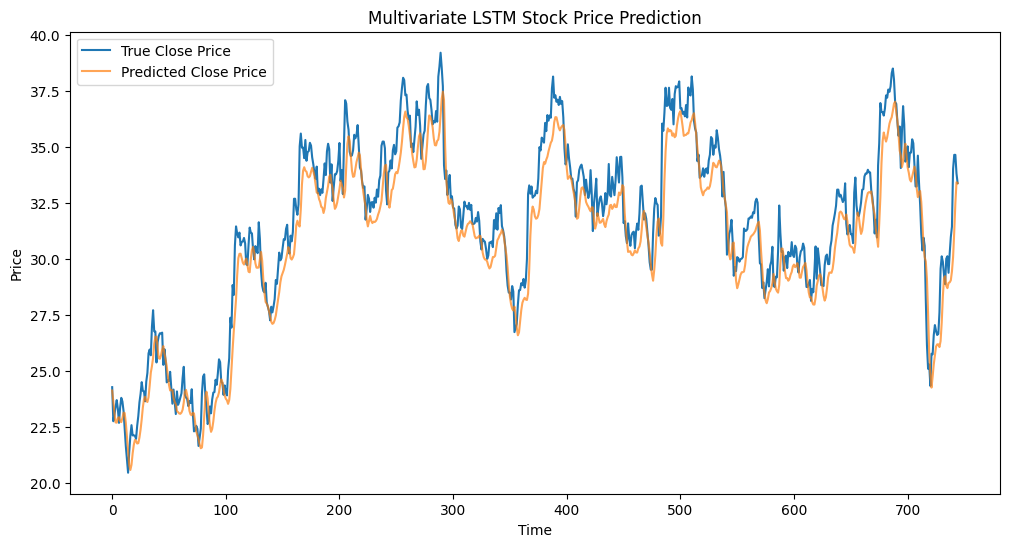

In [15]:
stock_daten.visual_result()

### Run model with saved data

In [20]:
stock = Stock_Model(SYMBOL, HISTORY, path='./resource')

In [22]:
print(stock._model_name)

IFX.DE_10y_1d_60


In [21]:
stock.train_model_with_loaded_data()

OSError: Unable to synchronously open file (file signature not found)

### load data from markt

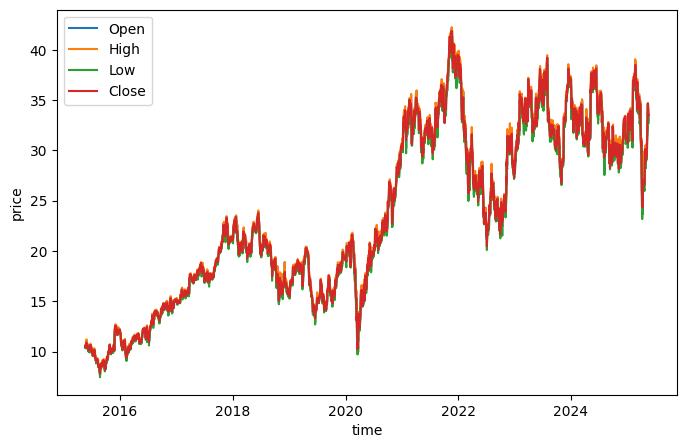

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8, 5))
plt.plot(stock_daten.stock_data[stock_daten.features[0][0]], label=stock_daten.features[0][0])
plt.plot(stock_daten.stock_data[stock_daten.features[0][1]], label=stock_daten.features[0][1])
plt.plot(stock_daten.stock_data[stock_daten.features[0][2]], label=stock_daten.features[0][2])
plt.plot(stock_daten.stock_data[stock_daten.features[0][3]], label=stock_daten.features[0][3])
#plt.xlim('2023.01.01', '2023.12.31')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()